## FIR low-pass design with window, firls and Parks–McClellan (remez)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.signal as sig


In [ ]:
# ----- Design specs -----
fs = 16000.0                  # "Digital" sampling rate so that Nyquist = 1.0
pass_band_fc = 3200.          # Pass-band cut-off frequency
stop_band_fc = 4000.          # Stop-band cut-off frequency
numtaps = 101                 # Filter length (odd -> linear phase)


bands = [0.0, pass_band_fc, stop_band_fc, fs/2.]
desired_firls = [1, 1, 0, 0]
desired_remez = [1, 0]          # Gain in each band
weights = [1, 10]               # Emphasize stopband error

# ----- Design via window (Blackman) method -----
# Cutoff at the midpoint of the transition band - Normalized Nyquist = 0.5 Hz (fs = 1.0 Hz)
# h_win = firwin(numtaps, cutoff=(pass_band_fc+stop_band_fc)/2, window='blackman', pass_zero='lowpass', fs=fs)

# ----- Design via window (Kaiser) method -----
# Target attenuation ~60 dB -> Kaiser beta via empirical formula
A = 60.0
beta = 0.0
if A > 50:
  beta = 0.1102 * (A - 8.7)
elif A >= 21:
  beta = 0.5842 * (A - 21)**0.4 + 0.07886 * (A - 21)
else:
  beta = 0.0

h_win = sig.firwin(numtaps, cutoff=(pass_band_fc+stop_band_fc)/2, window=('kaiser', beta), pass_zero='lowpass', fs=fs)

# ----- Design via least-squares (FIRLS) -----
h_firls = sig.firls(numtaps, bands,  desired_firls, weight=weights, fs=fs)

# ----- Design via Parks–McClellan (remez) -----
h_remez = sig.remez(numtaps, bands, desired_remez, weight=weights, fs=fs)

print(f'Passband: 0 to 0.2 (Fs=1.0)')
print(f'Stopband: 0.25 to 0.5')
print(f'Numtaps: {numtaps}')

# ----- Frequency response - window (Blackman) -----
w, H = sig.freqz(h_win, worN=4096, fs=fs)     # Frequency in Hz because fs provided
mag_db_win = 20*np.log10(np.maximum(np.abs(H), 1e-12))

# ----- Simple figures-of-merit -----
pb = w <= pass_band_fc
sb = w >= stop_band_fc
pb_ripple_db = np.max(mag_db_win[pb]) - np.min(mag_db_win[pb])
sb_atten_db = -np.max(mag_db_win[sb])

print(f'\nWindow (Blackman)')
print(f'Estimated passband ripple: {pb_ripple_db:.3f} dB')
print(f'Estimated worst-case stopband attenuation: {sb_atten_db:.1f} dB')

# ----- Frequency response - least-squares (FIRLS) -----
w, H = sig.freqz(h_firls, worN=4096, fs=fs)     # Frequency in Hz because fs provided
mag_db_firls = 20*np.log10(np.maximum(np.abs(H), 1e-12))

# ----- Simple figures-of-merit -----
pb_ripple_db = np.max(mag_db_firls[pb]) - np.min(mag_db_firls[pb])
sb_atten_db = -np.max(mag_db_firls[sb])

print(f'\nLeast-squares (FIRLS)')
print(f'Estimated passband ripple: {pb_ripple_db:.3f} dB')
print(f'Estimated worst-case stopband attenuation: {sb_atten_db:.1f} dB')

# ----- Frequency response - Parks–McClellan (remez) -----
w, H = sig.freqz(h_remez, worN=4096, fs=fs)
mag_db_remez = 20*np.log10(np.maximum(np.abs(H), 1e-12))

# ----- Simple figures-of-merit -----
pb_ripple_db = np.max(mag_db_remez[pb]) - np.min(mag_db_remez[pb])
sb_atten_db = -np.max(mag_db_remez[sb])

print(f'\nParks–McClellan (remez)')
print(f'Estimated passband ripple: {pb_ripple_db:.3f} dB')
print(f'Estimated worst-case stopband attenuation: {sb_atten_db:.1f} dB')



Passband: 0 to 0.2 (Fs=1.0)
Stopband: 0.25 to 0.5
Numtaps: 101

Window (Blackman)
Estimated passband ripple: 0.010 dB
Estimated worst-case stopband attenuation: 63.5 dB

Least-squares (FIRLS)
Estimated passband ripple: 0.005 dB
Estimated worst-case stopband attenuation: 76.4 dB

Parks–McClellan (remez)
Estimated passband ripple: 0.003 dB
Estimated worst-case stopband attenuation: 94.9 dB


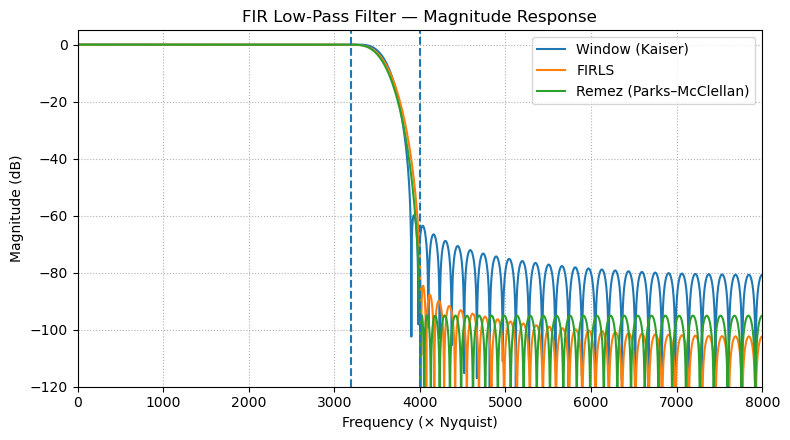

In [3]:
# ----- Plot magnitude response -----
plt.figure(figsize=(8,4.5))
plt.plot(w, mag_db_win, linewidth=1.5, label='Window (Kaiser)')
plt.plot(w, mag_db_firls, linewidth=1.5, label='FIRLS')
plt.plot(w, mag_db_remez, linewidth=1.5, label='Remez (Parks–McClellan)')
plt.axvline(pass_band_fc, linestyle="--")
plt.axvline(stop_band_fc, linestyle="--")
plt.xlim(0, fs/2)
plt.ylim(-120, 5)
plt.title("FIR Low-Pass Filter — Magnitude Response")
plt.xlabel("Frequency (× Nyquist)")
plt.ylabel("Magnitude (dB)")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.legend()


## Linear Phase Filter Frequency Shifting

 - Mirroring around the -6 dB point
 - Frequency reversal by negating alternate samples


For a great discussion on why you would want to mirror around the -6 dB point, see fred harris: DSP Online Conference 2024 - 19 - Digital Signal processing for Hearing Aids, Constant Q Filter Banks.


10


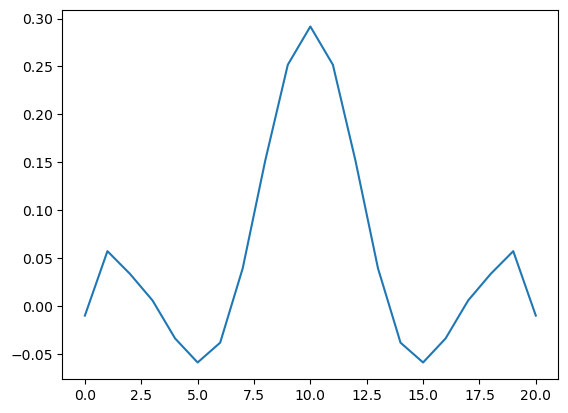

In [4]:
# Design a linear phase filter using Remez

# Define filter parameters
numTaps = 21  # Number of filter taps
fs = 48000.0   # Sampling frequency in Hz
bands = [0, 6000, 8000, 24000]  # Band edges in Hz
desired = [1, 0]  # Desired gain: passband (1) and stopband (0)

# Design the FIR filter
b = sig.remez(numTaps, bands, desired, fs=fs)

centerTap = numTaps//2
print(centerTap)

plt.plot(b)


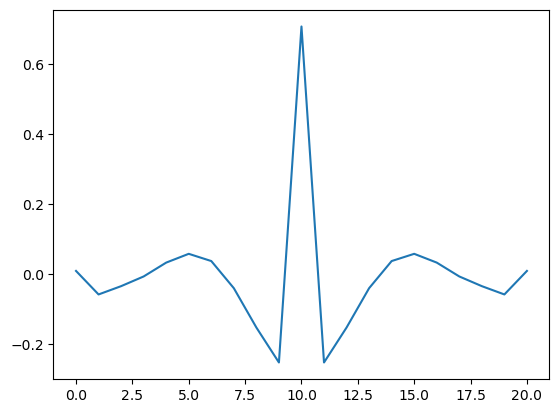

In [5]:
b_reflect_6db = b.copy()*-1
b_reflect_6db[len(b_reflect_6db)//2] = 1-b[len(b)//2]
plt.plot(b_reflect_6db)


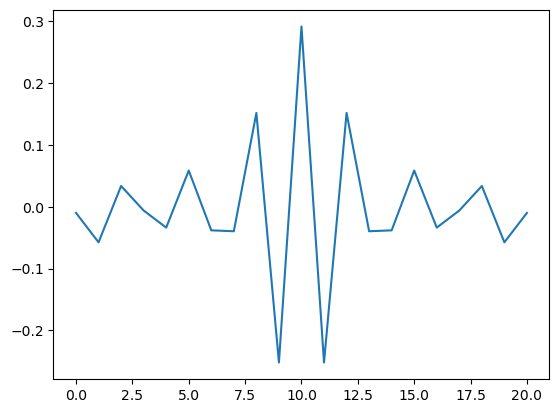

In [6]:
b_negate_alternate = b.copy()
neg=np.resize([1,-1], len(b))
b_negate_alternate = b*neg
plt.plot(b_negate_alternate)


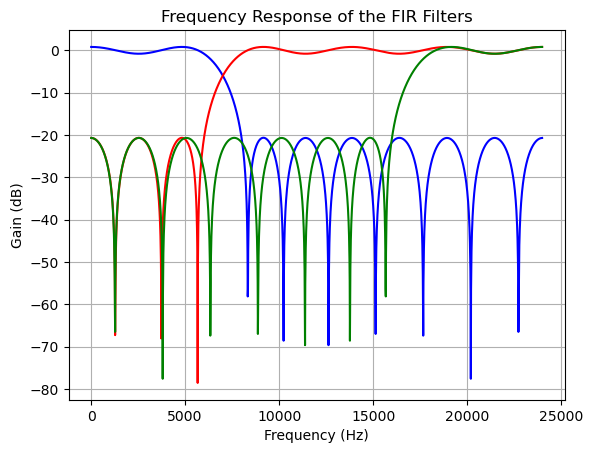

In [7]:
# Calculate frequency responses
w_b, h_b = sig.freqz(b, [1], worN=2000, fs=fs)
w_b_reflect_6db, h_b_reflect_6db = sig.freqz(b_reflect_6db, [1], worN=2000, fs=fs)
w_b_negate_alternate, h_b_negate_alternate = sig.freqz(b_negate_alternate, [1], worN=2000, fs=fs)

# Plot frequency responses
plt.figure()
plt.plot(w_b, 20 * np.log10(np.abs(h_b)), 'b')
plt.plot(w_b_reflect_6db, 20 * np.log10(np.abs(h_b_reflect_6db)), 'r')
plt.plot(w_b_negate_alternate, 20 * np.log10(np.abs(h_b_negate_alternate)), 'g')
plt.title('Frequency Response of the FIR Filters')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid(True)
plt.show()


## Compute minimum phase filter from linear phase filter

Linear Phase Filter
  - All zeros in the pass-band are symmetric across the unit circle

Minimum Phase Filter
  - All zeros outside the unit circle are mapped to inside the unit circle (located at same point as zeros inside)

Maximum Phase Filter
  - All zeros inside the unit circle are mapped to outside the unit circle (located at same point as zeros outside)

Steps to generate:
  - Write a python program to plot pole zero diagram of FIR filter
  - Write a python program to design an FIR filter using remez
  - Write a python program to convert linear phase filter to minimum phase
    - Oops, that didn't work!

Note: np.poly doesn't work very well for more than about 30 roots

In order to support larger filters it is necessary to:
  - Split the original filter into M smaller filters, taking every 1:M coefficients
  - Compute the linear phase to minimum phase version of each smaller filter
  - Combine all the smaller filters into the final filter by convolution


In [8]:
# Little function to generate pole-zero diagram for an FIR filter

def plot_pole_zero(b):
  """
  Plot the pole-zero diagram of an FIR filter given its coefficients.

  Parameters:
  b (array-like): Numerator (feedforward) coefficients of the FIR filter.
  """
  # Compute zeros
  zeros = np.roots(b)

  # FIR filters have all poles at the origin
  poles = np.zeros_like(zeros)  # This makes all poles at (0,0) for an FIR filter

  # Create a new figure
  plt.figure()

  # Plot zeros
  plt.scatter(zeros.real, zeros.imag, marker='o', s=50, edgecolor='b', facecolor='none', label='Zeros')

  # Plot poles
  # Since poles are all at the origin for FIR, we'll just plot a single marker at (0,0)
  plt.scatter(poles.real, poles.imag, marker='x', color='r', label='Poles')

  # Setup the plot: unit circle, axes, and labels
  unit_circle = Circle((0, 0), 1, color='gray', fill=False, linestyle='dashed')
  plt.gca().add_artist(unit_circle)
  plt.axhline(0, color='black', linewidth=1)
  plt.axvline(0, color='black', linewidth=1)
  plt.xlabel('Real Part')
  plt.ylabel('Imaginary Part')
  plt.title('Pole-Zero Plot')
  plt.grid(True)
  plt.axis('equal')
  plt.legend()
  plt.show()


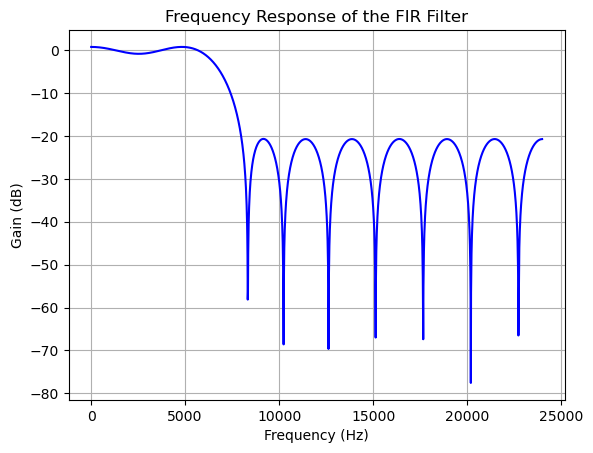

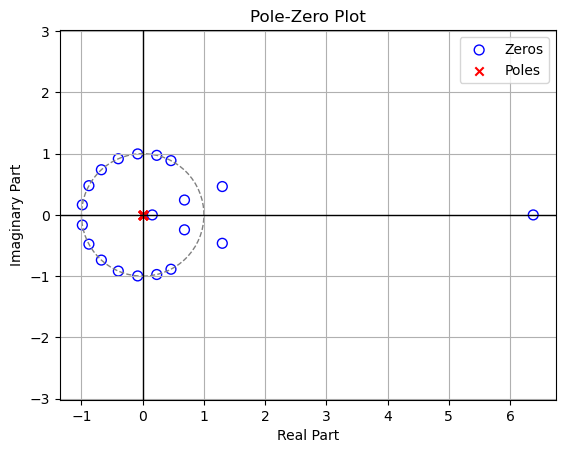

In [9]:
# Design a linear phase filter using Remez

# Define filter parameters
# numTaps = 101  # Number of filter taps
numTaps = 21  # Number of filter taps
fs = 48000.0   # Sampling frequency in Hz
bands = [0, 6000, 8000, 24000]  # Band edges in Hz
desired = [1, 0]  # Desired gain: passband (1) and stopband (0)

# Designthe FIR filter
b = sig.remez(numTaps, bands, desired, fs=fs)

# Calculate frequency response
w, h = sig.freqz(b, [1], worN=2000, fs=fs)

# Plot frequency response
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h)), 'b')
plt.title('Frequency Response of the FIR Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid(True)
plt.show()

# Plot pole-zero diagram
plot_pole_zero(b)


In [10]:
# Compute minimum phase filter from linear phase filter

def linear_phase_to_minimum_phase(b):
  rr1 = np.roots(b)                     # Calculate roots of the polynomial
  q1 = np.where(np.abs(rr1) >= 1.01)    # Identify roots with magnitude greater than or equal to 1.01

  rr1a = np.copy(rr1)                   # Modify the identified roots
  rr1a[q1] = 1.0 / rr1a[q1]

  yy = np.poly(rr1a)                    # Get polynomial coefficients from modified roots
  yy1 = yy / np.max(np.abs(np.fft.fft(yy, 512)))  # Normalize the polynomial coefficients
  rr2 = np.roots(yy1)                   # Calculate roots of the new polynomial
  return np.poly(rr2)                   # Output the final coefficients


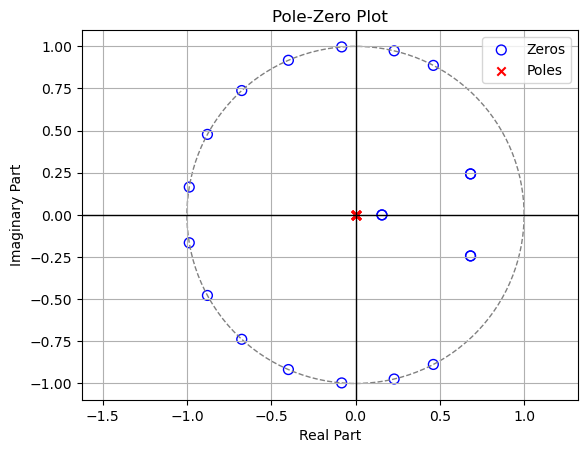

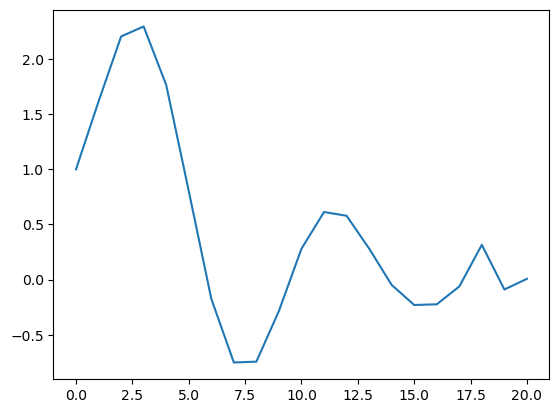

In [11]:
b_min = linear_phase_to_minimum_phase(b)
plot_pole_zero(b_min)
plt.plot(b_min)


In [12]:
# Compute maximum phase filter from linear phase filter
# Note: np.poly doesn't work very well for more than about 30 roots

def linear_phase_to_maximum_phase(b):
  rr1 = np.roots(b)                     # Calculate roots of the polynomial
  q1 = np.where(np.abs(rr1) <= .99)    # Identify roots with magnitude greater than or equal to 1.01

  rr1a = np.copy(rr1)                   # Modify the identified roots
  rr1a[q1] = 1.0 / rr1a[q1]

  yy = np.poly(rr1a)                    # Get polynomial coefficients from modified roots
  yy1 = yy / np.max(np.abs(np.fft.fft(yy, 512)))  # Normalize the polynomial coefficients
  rr2 = np.roots(yy1)                   # Calculate roots of the new polynomial
  return np.poly(rr2)                   # Output the final coefficients


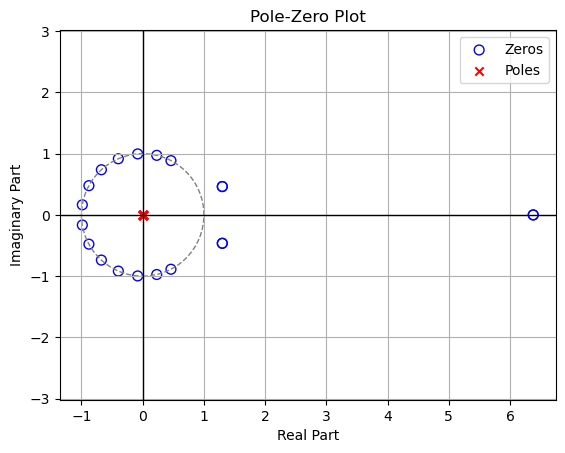

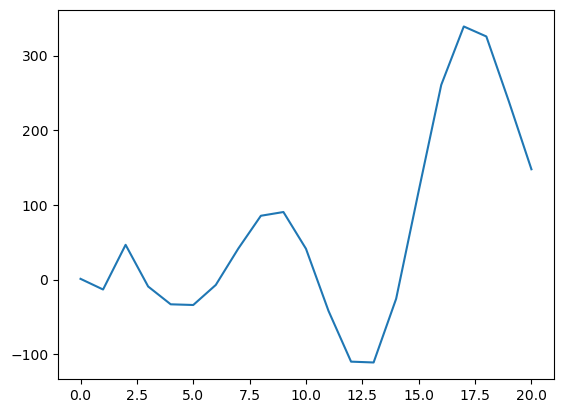

In [13]:
b_max = linear_phase_to_maximum_phase(b)
plot_pole_zero(b_max)
plt.plot(b_max)
